This tutorial demonstrates a basic usage of the image formation pipeline in `cryojax`.

It will demonstrate almost all of the modeling components that can be used when simulating a single image. This includes models for the instrument opticxs, electron dose rate, detector, and solvent. These models are all a work in progress.

In [1]:
# Jax imports
import jax

In [2]:
# Plotting imports and function definitions
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_image(image, fig, ax, cmap="gray", label=None, **kwargs):
    im = ax.imshow(image, cmap=cmap, origin="lower", **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    if label is not None:
        ax.set(title=label)
    return fig, ax

In [3]:
# CryoJAX imports
import cryojax.simulator as cxs

First we must read in our 3D scattering potential into a given voxel-based representation of the `potential`. Here, this is the `FourierVoxelGrid`. Then, we choose an integration method onto the exit plane.  Here, we use the fourier-slice projection theorem with the `FourierSliceExtract` integrator. In general, the `integrator` will depend on the scattering potential representation.

In [4]:
from cryojax.data import read_array_with_spacing_from_mrc


# Scattering potential stored in MRC format
filename = "./data/ribosome_4ug0_scattering_potential_from_cistem.mrc"
# Read template into a FourierVoxelGridPotential and choose an integrator
real_voxel_grid, voxel_size = read_array_with_spacing_from_mrc(filename)
potential = cxs.FourierVoxelGridPotential.from_real_voxel_grid(
    real_voxel_grid, voxel_size, pad_scale=2
)
# ... now, instantiate the pose. Angles are given in degrees
pose = cxs.EulerAnglePose(
    offset_x_in_angstroms=5.0,
    offset_y_in_angstroms=-3.0,
    view_phi=20.0,
    view_theta=80.0,
    view_psi=-10.0,
)
# ... now, build the ensemble. In this case, the ensemble is just one potential and a
# pose
potential_ensemble = cxs.BaseEnsemble(potential, pose)

Now, it's time to configure the imaging instrument. We can include models for the instrument optics, the electron dose, and the detector. Here, we create an instrument just with an optics model, and one that also includes a a detector model. We will see in a few lines why we have done this.

In [5]:
from cryojax.image import operators as op


# Initialize the scattering theory. First, instantiate fourier slice extraction
projection_method = cxs.FourierSliceExtract(interpolation_order=1)
# ... next, the contrast transfer theory
ctf = cxs.ContrastTransferFunction(
    defocus_u_in_angstroms=10000.0,
    defocus_v_in_angstroms=9800.0,
    astigmatism_angle=10.0,
    amplitude_contrast_ratio=0.1,
)
transfer_theory = cxs.ContrastTransferTheory(
    ctf, envelope=op.FourierGaussian(b_factor=5.0)
)
# ... add a colored noise model for the solvent
solvent = cxs.GaussianIce(
    variance=op.FourierExp2D(
        amplitude=0.005**2, length_scale=2.0 * potential.voxel_size
    )
)
# ... now for the scattering theory
scattering_theory = cxs.LinearScatteringTheory(
    potential_ensemble, projection_method, transfer_theory, solvent
)

Finally, we create an `ImageConfig` and initialize our `ImagePipeline`.

In [6]:
# Create the image configuration
config = cxs.ImageConfig(
    shape=(80, 80), pixel_size=potential.voxel_size, padded_shape=potential.shape[:2]
)
# ... and the instrument
instrument = cxs.Instrument(voltage_in_kilovolts=300.0)
# ... now, build the image formation model
pipeline = cxs.ImagePipeline(
    config=config, theory=scattering_theory, instrument=instrument
)

TypeError: ImagePipeline.__init__() got an unexpected keyword argument 'scattering_theory'

Before proceeding, we must create jit-compiled functions that simulate our images. We can either simulate the model without noise by calling the `pipeline.render()` function, or we can simulate an image with noise by calling the `pipeline.sample(key)` function, where `key` is a random number generator key.

In [ ]:
import equinox as eqx
from jaxtyping import PRNGKeyArray


@eqx.filter_jit
def compute_image(pipeline: cxs.ImagePipeline):
    """Simulate an image without noise from a `pipeline`."""
    return pipeline.render()


@eqx.filter_jit
def compute_noisy_image(pipeline: cxs.ImagePipeline, key: PRNGKeyArray):
    """Simulate an image with noise from a `pipeline`."""
    return pipeline.sample(key)

**What's with the eqx.filter_jit?**

This is an example of an equinox *filtered transformation*. In this case, the `eqx.filter_jit` decorator is a lightweight wrapper around `jax.jit` that treats all of the `pipeline`'s JAX arrays as traced at compile time, and all of its non-JAX arrays as static. Alternatively, we could have used the usual `jax.jit` decorator and explicitly passed traced and static pytrees to our function. It is completely optional to use `equinox` decorators.

Filtered transformations are a cornerstone to `equinox` and it is highly recommended to learn about them. See [here](https://docs.kidger.site/equinox/all-of-equinox/#2-filtering) in the equinox documentation for an introduction.

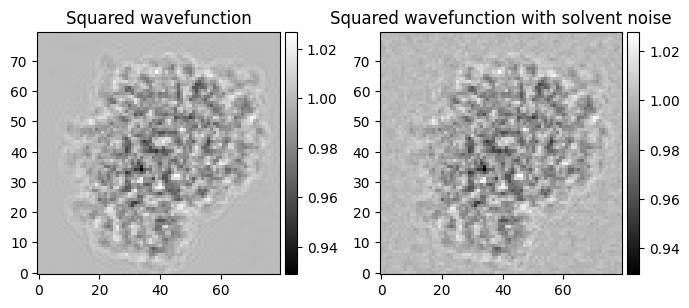

In [ ]:
# Simulate each image, drawing from the stochastic parts of the model
key = jax.random.PRNGKey(0)
fig, axes = plt.subplots(ncols=2, figsize=(7, 4))
ax1, ax2 = axes
im1 = plot_image(
    compute_image(pipeline),
    fig,
    ax1,
    label="Squared wavefunction",
)
im2 = plot_image(
    compute_noisy_image(pipeline, key),
    fig,
    ax2,
    label="Squared wavefunction with solvent noise",
)
plt.tight_layout()

Note that the `compute_noisy_image` function draws an image from the noise models contained in the image formation pipeline. These noise models are meant to be physical noise models, so in theory, these do not need to cleanly correspond to sampling from a particular statistical distribution. Alternatively, the user can simulate an image with a *distribution* from the `cryojax.inference.distributions` module.

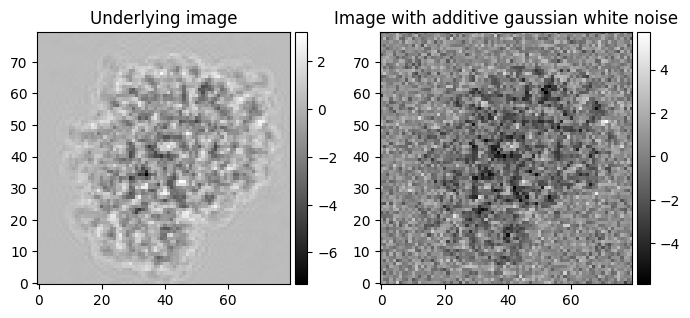

In [ ]:
from cryojax.image import operators as op
from cryojax.inference import distributions as dist


@eqx.filter_jit
def compute_image_with_distribution(distribution: dist.AbstractDistribution):
    """Simulate an image with noise from a `pipeline`."""
    return distribution.render()


@eqx.filter_jit
def compute_noisy_image_with_distribution(
    distribution: dist.AbstractDistribution, key: PRNGKeyArray
):
    """Simulate an image with noise from a `pipeline`."""
    return distribution.sample(key)


# Passing the ImagePipeline and a variance function, instantiate the distribution
distribution = dist.IndependentGaussianFourierModes(
    pipeline, contrast_scale=1.0, variance=op.Constant(1.0)
)
# ... then, either simulate an image from this distribution
key = jax.random.PRNGKey(seed=0)

fig, axes = plt.subplots(ncols=2, figsize=(7, 4))
ax1, ax2 = axes
im1 = plot_image(
    compute_image_with_distribution(distribution),
    fig,
    ax1,
    label="Underlying image",
)
im2 = plot_image(
    compute_noisy_image_with_distribution(distribution, key),
    fig,
    ax2,
    label="Image with additive gaussian white noise",
)
plt.tight_layout()

Here, we can directly control image SNR through the parameters `distribution.contrast_scale` (the standard deviation of the underlying signal) and `distribution.variance` (the variance of the gaussian noise). Note that when each are set to 1, like here, both images are returned to be mean zero and standard deviation one.

In [ ]:
image = compute_image_with_distribution(distribution)
print("Image mean:", image.mean())
print("Image standard deviation:", image.std())

Image mean: -3.7598609e-06
Image standard deviation: 0.99999994
